In [1]:
!pip install javalang pandas
!pip install pandas

In [2]:
!git clone https://github.com/microsoft/InferredBugs.git

Cloning into 'InferredBugs'...
remote: Enumerating objects: 60601, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 60601 (delta 420), reused 164 (delta 163), pack-reused 60167 (from 1)
Receiving objects: 100% (60601/60601), 58.70 MiB | 7.30 MiB/s, done.
Resolving deltas: 100% (7358/7358), done.
Updating files: 100% (67123/67123), done.


In [3]:
import os
import json
import pandas as pd
import re
from google.colab import files
from google.colab import files as colab_files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import pickle


In [4]:
import re

def combined_features(code_snippet):
    features = {
        # Memory leak and null dereference checks
        "public_constructor": "public constructor" in code_snippet,
        "static_instance_variable": "static " in code_snippet,
        "multiple_instances": code_snippet.count("new ") > 1,
        "direct_constructor_call_outside": "new " in code_snippet,
        "missing_finally_blocks": "finally" not in code_snippet,
        "no_try_with_resources": "try (" not in code_snippet,
        "no_explicit_close": "close()" not in code_snippet,
        "exceptions_not_handled": "catch (" not in code_snippet,
        "present_non_static_inner_classes": "class " in code_snippet and "static" not in code_snippet,
        "usage_of_ThreadLocals_set_null": "ThreadLocals.set(null)" in code_snippet,

        # Null-related checks
        "null_check_missing": "== null" in code_snippet and "if" not in code_snippet,
        "uninitialized_variables": "null" in code_snippet and ";" in code_snippet,
        "method_called_on_null": code_snippet.count("->") > 1 and "null" in code_snippet,
        "no_null_return_handling": "return null;" in code_snippet and "if" not in code_snippet,
        "null_check_after_dereference": "== null" in code_snippet and code_snippet.index("== null") > code_snippet.index("."),
        "nullable_annotations": len(re.findall(r'@\b(Nullable|NonNull)\b', code_snippet)) > 0,

        # Thread safety and synchronization checks
        "non_final_fields": len(re.findall(r'\b(private|protected|public)\s+\w+\s+\w+\s*;', code_snippet)),
        "static_fields": len(re.findall(r'\bstatic\b', code_snippet)),
        "synchronized_methods": len(re.findall(r'\bsynchronized\b\s+\w+\s*\(', code_snippet)),
        "synchronized_blocks": len(re.findall(r'\bsynchronized\s*\(', code_snippet)),
        "volatile_fields": len(re.findall(r'\bvolatile\b', code_snippet)),
        "inconsistent_synchronization": len(re.findall(r'\bsynchronized\b', code_snippet)) == 0,
        "nested_synchronization_depth": len(re.findall(r'\bsynchronized\b', code_snippet)) > 1,
        "external_method_calls_in_synchronized": len(re.findall(r'\bsynchronized\b\s*.*?\{.*?\w+\.\w+\(', code_snippet, re.DOTALL)),
        "lazy_initialization": len(re.findall(r'if\s*\(\w+\s*==\s*null\)\s*\{', code_snippet)),
        "double_checked_locking": len(re.findall(r'if\s*\(\w+\s*==\s*null\)\s*\{\s*synchronized', code_snippet)),
        "io_operations_in_synchronized": len(re.findall(r'synchronized\s*\{.*?(File|Socket|InputStream|OutputStream)\b', code_snippet, re.DOTALL)),
        "average_method_access_to_shared_fields": code_snippet.count("this."),
        "public_or_protected_shared_fields": len(re.findall(r'\b(public|protected)\s+\w+\s+\w+\s*;', code_snippet)),
        "method_calls_on_shared_resources": len(re.findall(r'\bthis\.\w+\(\)', code_snippet)),
        "thread_unsafe_patterns": len(re.findall(r'\b(ArrayList|HashMap|HashSet|LinkedList)\b', code_snippet)),
        "thread_safe_alternatives": len(re.findall(r'\b(ConcurrentHashMap|CopyOnWriteArrayList|ConcurrentLinkedQueue)\b', code_snippet)),

        # Additional checks
        "comments_with_keywords": len(re.findall(r'//.*\b(TODO|FIXME|HACK)\b', code_snippet, re.IGNORECASE)) > 0,
        "shared_resources_no_sync": len(re.findall(r'\b(List|HashMap|HashSet|Vector)\b', code_snippet)) > 0 and len(re.findall(r'\bsynchronized\b', code_snippet)) == 0,
        "num_variables_set_to_null": len(re.findall(r'=\s*null\b', code_snippet)),
        "num_resource_allocations": len(re.findall(r'\bnew\b', code_snippet)),
        "num_null_checks": len(re.findall(r'==\s*null\b', code_snippet)) + len(re.findall(r'!=\s*null\b', code_snippet)),
        "num_mutable_objects_used": len(re.findall(r'\b(ArrayList|HashMap|HashSet|LinkedList|Vector)\b', code_snippet)),
        "collection_access_patterns": len(re.findall(r'\.(add|remove|put|get)\b', code_snippet))
    }

    return features


In [5]:
import os
import json

java_directory = '/content/InferredBugs/inferredbugs/java'
bugs = {}

for root, dirs, files in os.walk(java_directory):
    for file in files:
        if file == 'bug.json':
            bug_file_path = os.path.join(root, file)
            with open(bug_file_path, 'r') as bug_file:
                bug_data = json.load(bug_file)
                bug_type = bug_data.get('bug_type')

                if bug_type == 'THREAD_SAFETY_VIOLATION':
                    bugs[bug_file_path] = 1
                elif bug_type == 'NULL_DEREFERENCE':
                    bugs[bug_file_path] = 0
                elif bug_type == 'RESOURCE_LEAK':
                    bugs[bug_file_path] = 2

In [7]:
features_list = []

for bug_file_path, bug_type in bugs.items():
    bug_directory = os.path.dirname(bug_file_path)
    code_file_path = os.path.join(bug_directory, 'file_before.txt')

    if os.path.exists(code_file_path):
        with open(code_file_path, 'r') as code_file:
            code_snippet = code_file.read()


            if bug_type == 1:  # THREAD_SAFETY_VIOLATION
                features = combined_features(code_snippet)
            elif bug_type == 0:  # NULL_DEREFERENCE
                features = combined_features(code_snippet)
            elif bug_type == 2:  # RESOURCE_LEAK
                features = combined_features(code_snippet)

            features['file_name'] = os.path.relpath(bug_directory, java_directory) + '/file_before.txt'
            features["bug_type"] = bug_type
            features_list.append(features)


In [8]:
features_df = pd.DataFrame(features_list)

In [9]:
if not features_df.empty:
    csv_file_path_memory = '/content/combined_features.csv'
    features_df.to_csv(csv_file_path_memory, index=False)

    print(f'Saved features to {csv_file_path_memory}')

    try:
        colab_files.download(csv_file_path_memory)
    except Exception as e:
        print(f"An error occurred while downloading: {e}")
else:
    print("No features extracted. DataFrame is empty.")

Saved features to /content/combined_features.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
features_df.shape

(8123, 41)

In [11]:
features_df.head()

,public_constructor,static_instance_variable,multiple_instances,direct_constructor_call_outside,missing_finally_blocks,no_try_with_resources,no_explicit_close,exceptions_not_handled,present_non_static_inner_classes,usage_of_ThreadLocals_set_null,...,thread_safe_alternatives,comments_with_keywords,shared_resources_no_sync,num_variables_set_to_null,num_resource_allocations,num_null_checks,num_mutable_objects_used,collection_access_patterns,file_name,bug_type
0,False,False,True,True,True,True,True,True,True,False,...,0,False,True,3,3,2,2,10,hierarchical-clustering-java/1/file_before.txt,0
1,False,True,True,True,True,True,True,True,False,False,...,0,False,False,0,11,0,0,3,red5-client/1/file_before.txt,1
2,False,False,True,True,True,True,False,False,True,False,...,0,False,True,3,10,3,0,0,gwt-maven-plugin/1/file_before.txt,2
3,False,False,True,True,True,True,False,False,True,False,...,0,False,True,3,10,3,0,0,gwt-maven-plugin/2/file_before.txt,2
4,False,False,True,True,True,True,True,False,True,False,...,0,False,True,10,5,10,3,5,litemall/1/file_before.txt,0


In [12]:
features_df.columns

Index(['public_constructor', 'static_instance_variable', 'multiple_instances',
       'direct_constructor_call_outside', 'missing_finally_blocks',
       'no_try_with_resources', 'no_explicit_close', 'exceptions_not_handled',
       'present_non_static_inner_classes', 'usage_of_ThreadLocals_set_null',
       'null_check_missing', 'uninitialized_variables',
       'method_called_on_null', 'no_null_return_handling',
       'null_check_after_dereference', 'nullable_annotations',
       'non_final_fields', 'static_fields', 'synchronized_methods',
       'synchronized_blocks', 'volatile_fields',
       'inconsistent_synchronization', 'nested_synchronization_depth',
       'external_method_calls_in_synchronized', 'lazy_initialization',
       'double_checked_locking', 'io_operations_in_synchronized',
       'average_method_access_to_shared_fields',
       'public_or_protected_shared_fields', 'method_calls_on_shared_resources',
       'thread_unsafe_patterns', 'thread_safe_alternatives',
    

In [13]:
bug_counts = features_df['bug_type'].value_counts()
bug_counts

,count
bug_type,
0,3338
2,2899
1,1886


In [14]:
X = features_df.drop(columns=["bug_type", "file_name"])
y = features_df["bug_type"]

In [15]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

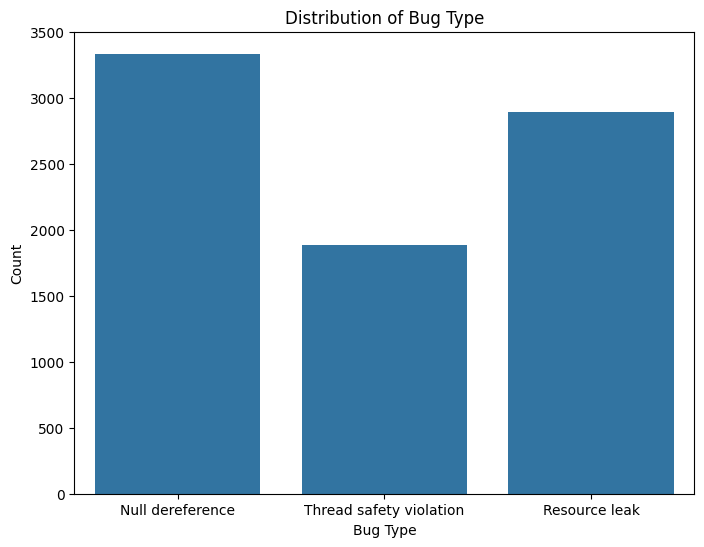

In [17]:
# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=bug_counts.index, y=bug_counts.values)
plt.title('Distribution of Bug Type')
plt.xlabel('Bug Type')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Null dereference', 'Thread safety violation', 'Resource leak'])
plt.show()

In [18]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

In [19]:
# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Make predictions
y_pred = rf_classifier.predict(X_test)

In [21]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8830769230769231


In [22]:
report_rf = classification_report(y_test, y_pred)
print("Classification Report - Random Forest:\n", report_rf)

Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       663
           1       0.90      0.94      0.92       367
           2       0.90      0.85      0.88       595

    accuracy                           0.88      1625
   macro avg       0.89      0.89      0.89      1625
weighted avg       0.88      0.88      0.88      1625



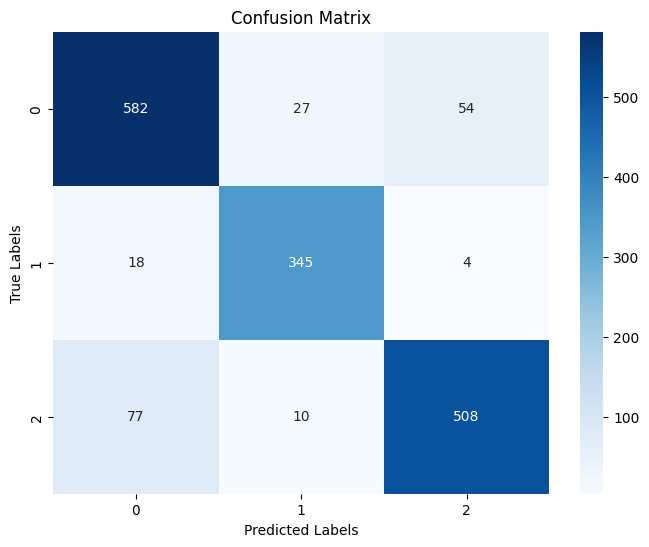

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [24]:
# Save the model to a file
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

In [25]:
if len(set(y_test)) == 2:
    y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
    print(f'ROC-AUC Score - Random Forest: {roc_auc_rf:.2f}')

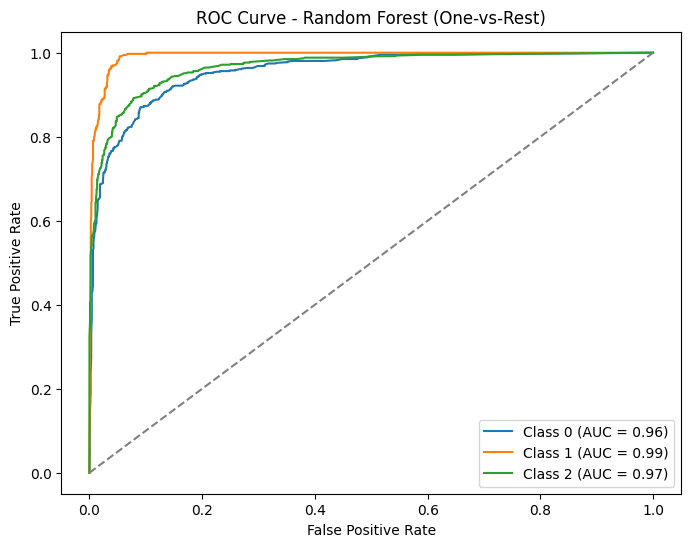

Average ROC-AUC Score: 0.97


In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

y_pred_proba_rf = rf_classifier.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(y_test_binarized.shape[1]):
    falsepr, truepr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba_rf[:, i])
    roc_auc = auc(falsepr, truepr)
    plt.plot(falsepr, truepr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# average ROC AUC score for multiclass
average_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba_rf, average="macro")
print(f'Average ROC-AUC Score: {average_roc_auc:.2f}')


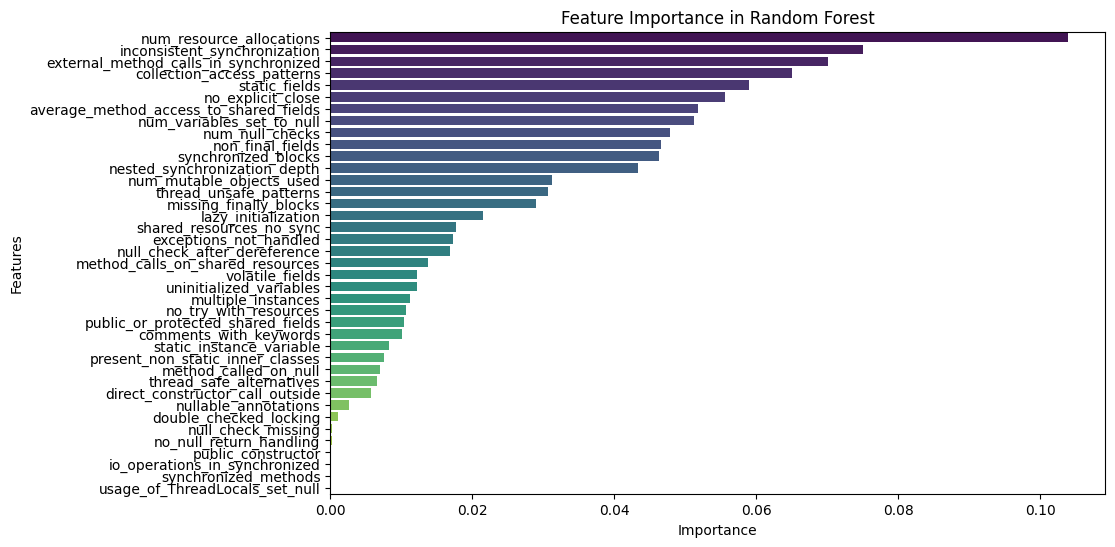

In [28]:
feature_importances = rf_classifier.feature_importances_


importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', dodge=False, palette='viridis', legend=False)
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()




In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best Parameters from Grid Search: {best_params}')

best_rf_classifier = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters from Grid Search: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [31]:
from sklearn.model_selection import cross_val_score

num_classes = len(set(y))

if num_classes == 2:
    cv_scores = cross_val_score(best_rf_classifier, X, y, cv=5, scoring='roc_auc')
    print(f'Cross-Validation ROC-AUC Scores (Binary): {cv_scores}')
else:
    cv_scores = cross_val_score(best_rf_classifier, X, y, cv=5, scoring='roc_auc_ovr')
    print(f'Cross-Validation ROC-AUC Scores (Multiclass): {cv_scores}')

print(f'Mean ROC-AUC Score from Cross-Validation: {cv_scores.mean():.2f}')

Cross-Validation ROC-AUC Scores (Multiclass): [0.86550814 0.86268278 0.83883247 0.85478547 0.86013258]
Mean ROC-AUC Score from Cross-Validation: 0.86
